<a href="https://colab.research.google.com/github/its-snowy/NeuroScan-AI/blob/main/Brain_MRI_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib scikit-learn

In [ ]:
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
zip_file_name = 'mri brain scan.zip'
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('mri brain scan')

base_dir = 'mri brain scan'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 5619 images belonging to 4 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1404 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7023 images belonging to 4 classes.


In [ ]:
print("Kelas yang terdeteksi:")
for class_name, class_index in train_generator.class_indices.items():
    print(f"- {class_name} (index: {class_index})")
print(f"Total kelas: {len(train_generator.class_indices)}")
print(f"Total sampel training: {train_generator.samples}")
print(f"Total sampel validasi: {validation_generator.samples}")
print(f"Total sampel test: {test_generator.samples}")

Kelas yang terdeteksi:
- glioma (index: 0)
- healthy (index: 1)
- meningioma (index: 2)
- pituitary (index: 3)
Total kelas: 4
Total sampel training: 5619
Total sampel validasi: 1404
Total sampel test: 7023


In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

In [ ]:
# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9275 - loss: 0.2236
Epoch 1: val_accuracy improved from 0.94872 to 0.96083, saving model to best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 128s 712ms/step - accuracy: 0.9275 - loss: 0.2236 - val_accuracy: 0.9608 - val_loss: 0.1223 - learning_rate: 1.0000e-05
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9341 - loss: 0.1977
Epoch 2: val_accuracy did not improve from 0.96083
176/176 ━━━━━━━━━━━━━━━━━━━━ 120s 668ms/step - accuracy: 0.9341 - loss: 0.1977 - val_accuracy: 0.9566 - val_loss: 0.1153 - learning_rate: 1.0000e-05
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9501 - loss: 0.1556
Epoch 3: val_accuracy did not improve from 0.96083
176/176 ━━━━━━━━━━━━━━━━━━━━ 120s 666ms/step - accuracy: 0.9501 - loss: 0.1556 - val_accuracy: 0.9095 - val_loss: 0.2489 - learning_rate: 1.0000e-05
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9405 - loss: 0.1800
Epoch 4: val_a

220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.9686 - loss: 0.0907
Test accuracy: 0.9626


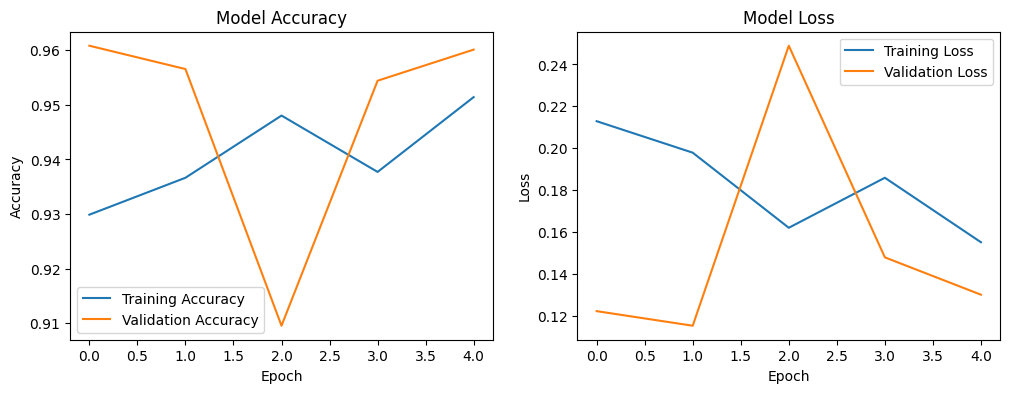

220/220 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step


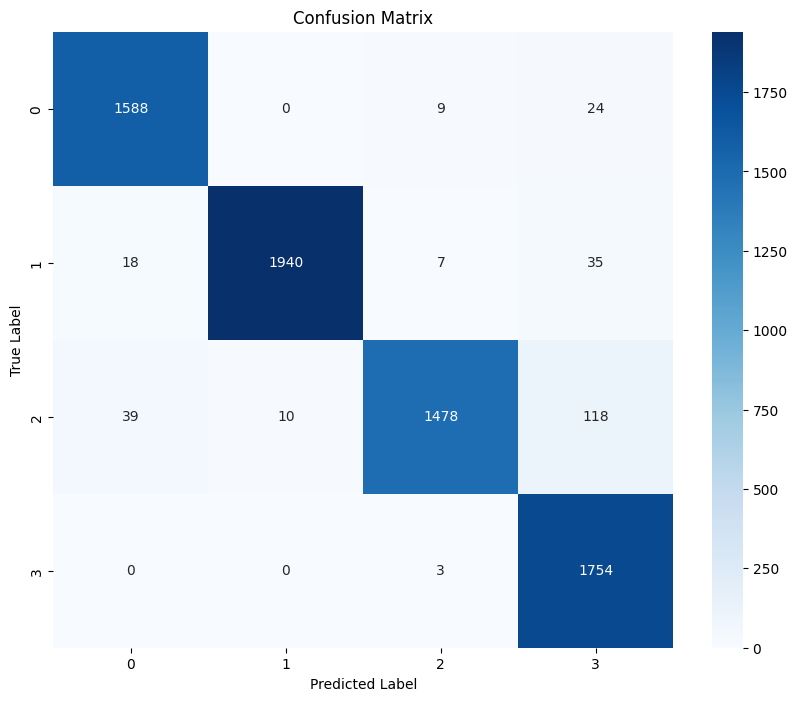

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97      1621
     healthy       0.99      0.97      0.98      2000
  meningioma       0.99      0.90      0.94      1645
   pituitary       0.91      1.00      0.95      1757

    accuracy                           0.96      7023
   macro avg       0.96      0.96      0.96      7023
weighted avg       0.96      0.96      0.96      7023



In [ ]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[np.argmax(prediction)]
    return predicted_class

In [ ]:
predicted_label = predict_image('glioma2.jpg')
print(f'Predicted label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted label: glioma


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('best_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mri_model.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_73>, <KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_74>]

In [ ]:
model = tf.keras.models.load_model('best_model.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model as a .tflite file
with open('mri_model.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_159>, <KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_160>]

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,705,806 (181.98 MB)

 Trainable params: 15,900,740 (60.66 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 31,801,482 (121.31 MB)